## Import neccessary libraries

In [1]:
import pandas as pd
import numpy as np
import time
import gc
import psutil
import os
import matplotlib.pyplot as plt

# All function in this jupyter lab file is defined in the library/python file below
import CS5901_import

## Stage 0. Code respiratory

### For this stage, I'm going to include the respiratory link on git, and all commands used to push all local coding files to git

1. Github respiratory link

2. All commands used to push local folder to git

## Stage 1. Code respiratory

### 0. Import the data as a pandas dataframe

In [8]:
# Locate the file path
file_path = 'P2data9603.csv'

# Read the CSV file, tab is delimeter
df = pd.read_csv(file_path,  delimiter='\t')

# Display 1st 5 rows
df.head(5)

,Level,T4,T3,T3adjusted,T4adjusted
0,5,8.7,NaN,2.056710,NaN
1,20,7.9,4.6,1.991632,1.663103
2,30,2.3,0.4,1.320006,0.736806
3,20,5.4,2.6,1.754411,1.375069
4,5,1.8,NaN,1.216440,NaN


### 1. Identify and remove any data rows that make no sense

After doing my research with a bit of imagination, I speculate that the dataset arised from a clinical study, in which:
- Level Column => represents different levels in which the hormone level clinical test was conducted
- T3 Column => Can be a specific factor of measurement, I assume it is the Triiodothyronine (T3) levels.
- T3 Column => Also specific factor of measurement, which I assues is Thyroxine (T4) levels

Thus, I conclude that there are two possible scenarios in which the rows exhibit illogical data:

**1st Possibility:** Both `T3` and `T4` are NA, basically means the test does not have any value, so we will remove those


In [9]:
remove_condition_1 = df['T3'].isna() & df['T4'].isna()

**2nd Possibility:**  
I assume that there exists outliers in column `T3` and `T4`.    
These outliers must be excluded since in step 2 we are calculating average value.   
First of all, to inspect the outliers in column `T3` and `T4`, we will use matplotlib lib to create a distribution graph for both column

In [10]:
help(CS5901_import.plot_distribution)

Help on function plot_distribution in module CS5901_import:

plot_distribution(df, column)
    Plot the distribution of a specified column in a DataFrame, take input a dataframe and one column



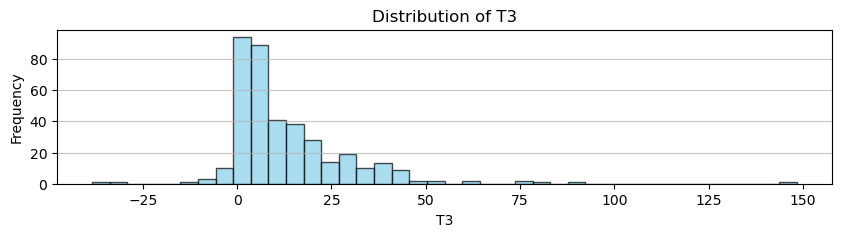

In [11]:
CS5901_import.plot_distribution(df, 'T3')

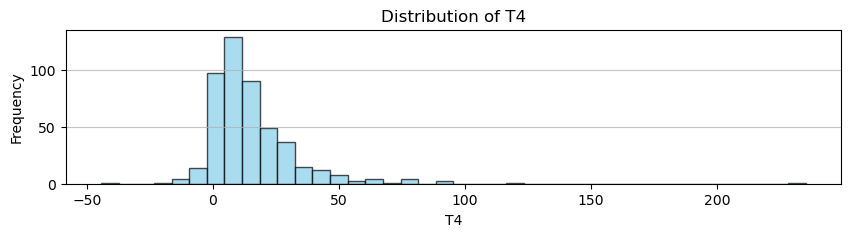

In [12]:
CS5901_import.plot_distribution(df, 'T4')

The graph shows that there are very few values in both columns that fall below -25 or exceed 100, so we will remove those rows.

In [13]:
remove_condition_2 = (df['T3'] <= -25) | (df['T3'] >= 100) 
remove_condition_3 = (df['T4'] <= -25) | (df['T4'] >= 100)

# All remove condition combined
remove_condition = (
    remove_condition_1 |
    remove_condition_2 |
    remove_condition_3
)

# Remove all rows that match combine condition
df_filtered = df[~remove_condition]

# Print original and filtered DataFrame lengths and number of rows lost
original_length = len(df)
filtered_length = len(df_filtered)
rows_lost = original_length - filtered_length

print('Original df length:', original_length)
print('Filtered df length:', filtered_length)
print('Total number of rows lost:', rows_lost)


Original df length: 482
Filtered df length: 473
Total number of rows lost: 9


### 2. Replace any missing values in `T3` and `T4` with average values **for their specific level**

First of all, we write a function to calculate the average value of both column `T3` and `T4` for all of its level, then stored the result inside a dict with the keys being the level

In [14]:
help(CS5901_import.average_by_level)

Help on function average_by_level in module CS5901_import:

average_by_level(df, level_col, value_col)
    Calculate average value by level of a T column of dataframe and return the result as dict
    Take 3 input: dataframe, level column, value column of T



In [15]:
result_dict_t3 = CS5901_import.average_by_level(df_filtered, 'Level', 'T3')
result_dict_t4 = CS5901_import.average_by_level(df_filtered, 'Level', 'T4')
print('result_dict_t3: ', result_dict_t3)  # Output: {1: 3.5, 2: 4.0}
print('result_dict_t4: ', result_dict_t4)  # Output: {1: 3.5, 2: 4.0}

result_dict_t3:  {5: 4.046789088941176, 10: 7.888769370518988, 15: 13.12573882932258, 20: 16.98489312623387, 25: 26.633333333333336, 30: 10.536367385954545, 40: 19.28690435711628, 50: 4.4221725162, 60: 29.2, 100: 22.185714285714283, 150: 13.4, 200: 15.785714285714283, 300: 8.025, 400: 5.622222222222223}
result_dict_t4:  {5: 7.245631097280701, 10: 12.637046965698925, 15: 17.73585067425581, 20: 15.903931173888113, 25: 27.11111111, 30: 21.572104588625, 40: 19.42351100066, 50: 4.8899489577, 60: 17.2, 100: 21.157142857142855, 150: 15.080000000000002, 200: 11.644444444444446, 300: 4.175000000000001, 400: 3.888888888888889}


Then, we use the apply method applicable to dataframe to fill the NA value of T3 and T4 with the result obtained from the dict

In [18]:
help(CS5901_import.fill_value)

Help on function fill_value in module CS5901_import:

fill_value(row, value_col, result_dict)
    Fill NaN values in a T column with corresponding average values from a dictionary 
    Only if T column is null, otherwise returns original value



In [19]:
df_filtered1 = df_filtered.copy()
df_filtered1.loc[:, 'T3'] = df_filtered1.apply(CS5901_import.fill_value, axis=1, args=('T3', result_dict_t3))
df_filtered1.loc[:, 'T4'] = df_filtered1.apply(CS5901_import.fill_value, axis=1, args=('T4', result_dict_t4))

Just to be sure, I ran a few lines of code to compare the DataFrame before and after filling the NA values in column T4.

In [20]:
print(result_dict_t4[10], result_dict_t4[20])  #=> This is average T4 value for level 10 + 20

12.637046965698925 15.903931173888113


In [21]:
df_filtered[df_filtered['T4'].isna()].tail(2) # => This is before filling T4 with NA value

,Level,T4,T3,T3adjusted,T4adjusted
296,10,NaN,31.3600,0.0,3.153494
386,20,NaN,20.7375,0.0,2.747380


In [22]:
df_filtered1[df_filtered['T4'].isna()].tail(2) # => This is after filling T4 with NA value

,Level,T4,T3,T3adjusted,T4adjusted
296,10,12.6,31.4,0.0,3.153494
386,20,15.9,20.7,0.0,2.747380


### 3. Write code - without using *pandas.describe()* - that presents a table of descriptive statistics for each column, then compare you results to those obtained using *pandas.describe()*

Writing the `custom_describe` function as replace ment for the pandas describe method

In [23]:
help(CS5901_import.custom_describe)

Help on function custom_describe in module CS5901_import:

custom_describe(df)
    Calculate descriptive statistics for each column in the DataFrame.
    Receive the whole dataframe as input
    How it works: 
    1. Each keys in the dict contained a measure of every columns in dataframe, in a form a pandas series
    2. The dict is converted back into a dataframe, and transposed for the dimension to match the original describe method



In [25]:
custom_stats = CS5901_import.custom_describe(df)
print("Custom Descriptive Statistics (Transposed):")
print(custom_stats)

Custom Descriptive Statistics (Transposed):
            Level          T4          T3  T3adjusted  T4adjusted
count  482.000000  472.000000  382.000000  476.000000  381.000000
mean    34.885892   15.227682   13.087924    2.031534    1.902634
std     64.299661   19.201461   16.470182    1.257578    1.224463
min      5.000000  -44.400000  -38.400000   -3.541014   -3.373731
25%     10.000000    4.663806    3.125000    1.645850    1.473613
50%     20.000000   10.996296    7.950000    2.218938    2.000000
75%     30.000000   19.800000   18.700000    2.701918    2.654283
max    400.000000  235.200000  148.400000    6.172756    5.294334


It's matching closely with the original describe method

In [26]:
pandas_stats = df.describe()
print("The Describe method")
print(pandas_stats)

The Describe method
            Level          T4          T3  T3adjusted  T4adjusted
count  482.000000  472.000000  382.000000  476.000000  381.000000
mean    34.885892   15.227682   13.087924    2.031534    1.902634
std     64.299661   19.201461   16.470182    1.257578    1.224463
min      5.000000  -44.400000  -38.400000   -3.541014   -3.373731
25%     10.000000    4.663806    3.125000    1.645850    1.473613
50%     20.000000   10.996296    7.950000    2.218938    2.000000
75%     30.000000   19.800000   18.700000    2.701918    2.654283
max    400.000000  235.200000  148.400000    6.172756    5.294334


## 4. Write code that identifies any repeated rows or confirms that there are none

In order to identify repeated rows, we simply make a new column which contains the concatenate value of all 5 columns

In [15]:
df_filtered1['Dup check ID'] = (
    df_filtered1['Level'].astype(str).fillna('') + 
    df_filtered1['T4'].astype(str).fillna('') + 
    df_filtered1['T3'].astype(str).fillna('') + 
    df_filtered1['T3adjusted'].astype(str).fillna('') + 
    df_filtered1['T4adjusted'].astype(str).fillna('')
)

df_filtered1.head(2)

,Level,T4,T3,T3adjusted,T4adjusted,Dup check ID
0,5,8.7,4.0,2.056710,NaN,58.74.02.056710116nan
1,20,7.9,4.6,1.991632,1.663103,207.94.61.9916317011.663103499


Then, we count value of column Dup check partition by the column it self, and filter rows where that value >1 to identify al duplicated rows

In [16]:
df_filtered1['Dup check count'] = df_filtered1['Dup check ID'].map(df_filtered1['Dup check ID'].value_counts())
df_filtered2 = df_filtered1[df_filtered1['Dup check count'] > 1].copy()
df_filtered2 = df_filtered2.sort_values(by='Dup check ID')
df_filtered2.head(4)

,Level,T4,T3,T3adjusted,T4adjusted,Dup check ID,Dup check count
473,100,18.7,9.1,2.654283,2.087759,10018.79.12.6542828572.087759479,2
132,100,18.7,9.1,2.654283,2.087759,10018.79.12.6542828572.087759479,2
108,100,19.1,17.8,2.673075,2.610999,10019.117.82.6730748662.610998771,2
472,100,19.1,17.8,2.673075,2.610999,10019.117.82.6730748662.610998771,2


## Stage 2. Code respiratory

### 1. Let's take a look at the function and understand what it does

The function myInv(size) explanation

In [17]:
def myInv(size):

    # 1. Generate a square matrix `intA` of random integers with values between -500 and 50000.
    intA = np.random.randint(-500,50000, (size,size))

    # 2. Generate a square matrix `intA` of random float with values between 0 and 1.
    flA = np.random.rand(size,size)

    # 3. Combine `intA` and `flA` to create the matrix `A`.
    A = intA + flA

    # 4. This generated vector is not used to do anything.
    b = np.random.randint(-10,100,size)

    # 5. Return the inverse of the matrix `A` using numpy's `np.linalg.inv()` function
    return(np.linalg.inv(A))

Detailed explanation to demonstrate understanding of the loop that calculates time and space.

In [45]:
process = psutil.Process(os.getpid()) # `process` variable creates a process object for the current python process
baseRam = process.memory_info().rss # `baseRam` records the initial memory usage, before running anything
# => Both of these variables will be used to calculate resSpace (memory usage) in the next loop

resTime = np.zeros(10) # Creates a NumPy array filled with 10 zero elements
resSpace = np.zeros(10) # Same with above 

for i in range(1,11):
    gc.collect() # gc.collect() must be triggered before loop iteration since it prevented memory buildup. Without it, resSpace may be inaccurate because unused memory from previous iterations might not be freed
    
    start = time.time() # Record the start time before running myInv function
    
    myInv(i*1000) # Running the myInv function, x1000 to the currect loop as the `intA` and `flA` matrix size
    
    end = time.time() # Record the start time of each loop
    
    ram = process.memory_info().rss # The variable ram records the memory usage of the current loop iteration 
    
    resTime[i-1] = end - start # It calculates the process time for the current loop, result is stored into resTime array with corresponding index
    resSpace[i-1] = ram - baseRam # It calculates the process memory for the current loop, result is stored into resSpace array with corresponding index
    
print(resTime)
print(resSpace)

[ 0.04388332  0.23641682  0.6651814   1.4226656   2.23490286  3.69680047
  5.57696509  7.98066759 10.66968226 14.41760921]
[      0. 3149824. 4747264. 4747264. 4763648. 4767744. 4767744. 4771840.
 4775936. 4780032.]


### 2. Using adaptations of the code above and investigate the time and space needed for standard matrix multiplication (for time this should be $cn^3$ where $c$ is a non-negative constant)

We define a function for matrix multiplication.

In [27]:
help(CS5901_import.matrix_mult)

Help on function matrix_mult in module CS5901_import:

matrix_mult(size)
    Standard cn^3 matrix multiplication with matrices A and B



Next, we are going to run a loop. With each iteration, we create a different random matrix with increasing dimension

In [ ]:
process = psutil.Process(os.getpid()) 
baseRam = process.memory_info().rss 

resTime_sort = np.zeros(10)
resSpace_sort = np.zeros(10)

for i in range(1, 11):
    gc.collect()
    start = time.time()
    CS5901_import.matrix_mult(i * 1000)
    end = time.time()
    ram = process.memory_info().rss    
    resTime_sort[i-1] = end - start
    resSpace_sort[i-1] = ram - baseRam
    
print("Selection Sort Times:", resTime_sort)
print("Selection Sort Space:", resSpace_sort)

Selection Sort Times: [ 0.02293992  0.16555572  0.39893365  0.83040237  1.53576398  2.52212882
  3.76822639  5.54505706  7.63972068 10.53532887]
Selection Sort Space: [ 4800512. 14929920. 19345408. 20852736. 22425600. 25141248. 28286976.
 31301632. 31301632. 31301632.]


### 3. sorting an unordered list of integers inefficiently by searching for the smallest element, then the next smallest,...

We define a function to sort through the list

In [28]:
help(CS5901_import.selection_sort)

CS5901_import.selection_sort([3,5,4,1])

Help on function selection_sort in module CS5901_import:

selection_sort(random_list)
    Sorts through a list inefficiently by finding the smallest component in the list
    and repositioned each component in the list
    This will take a list as input and return the sorted list



[1, 3, 4, 5]

Next, we are going to run a loop. With each iteration, we create a different random list with increasing length (i*1000 length)

In [ ]:
process = psutil.Process(os.getpid()) 
baseRam = process.memory_info().rss 

resTime_sort = np.zeros(10)
resSpace_sort = np.zeros(10)

for i in range(1, 11):
    gc.collect()
    random_list = np.random.randint(0, 1000, i * 1000).tolist()
    start = time.time()
    CS5901_import.selection_sort(random_list)
    end = time.time()
    ram = process.memory_info().rss    
    resTime_sort[i-1] = end - start
    resSpace_sort[i-1] = ram - baseRam
    
print("Selection Sort Times:", resTime_sort)
print("Selection Sort Space:", resSpace_sort)

Selection Sort Times: [0.01097012 0.04286098 0.09474468 0.16905308 0.26222658 0.38189054
 0.52211356 0.70125675 0.88015127 1.07310414]
Selection Sort Space: [     0.  12288.  20480.  20480.  57344.  81920.  81920.  81920.  81920.
 159744.]


### 4. A comparison of Python's *find()* method and your loop-based implementation of a method that checks if one string is a substring of another

We define a function to iterate the main string, searching for the substring

In [29]:
help(CS5901_import.is_substring)


main_string = "hello world"
substring = "world"
print(CS5901_import.is_substring(substring, main_string))  


Help on function is_substring in module CS5901_import:

is_substring(substring, main_string)
    Sorts through each slice in the main string looking for the substring
    This function requires 2 inputs: substring and the mainstring
    In case the substring match the mainstring, it returns TRUE

True


Next, we are going to run 2 loop. Each loop check for time and space of one of the two methods

In [ ]:
process = psutil.Process(os.getpid()) 
baseRam = process.memory_info().rss 

main_string = "a" * 1000  # A long string of 'a' characters
substring = "a" * 100  # A short pattern to search for

resTime_find = np.zeros(10)
resSpace_find = np.zeros(10)

resSpace_loop = np.zeros(10)
resTime_loop = np.zeros(10)

for i in range(1, 11):
    gc.collect()
    start = time.perf_counter()
    CS5901_import.is_substring(substring, main_string)
    end = time.perf_counter()
    ram = process.memory_info().rss    
    resTime_find[i-1] = end - start
    resSpace_find[i-1] = ram - baseRam

for i in range(1, 11):
    gc.collect()
    start = time.perf_counter()
    CS5901_import.is_substring(substring, main_string)
    end = time.perf_counter()
    ram = process.memory_info().rss    
    resTime_loop[i-1] = end - start
    resSpace_loop[i-1] = ram - baseRam

print("Find() Method Times:", resTime_find)
print("Loop Method Times:", resTime_loop)
print("")
print("Find() Method Space:", resSpace_find)
print("Loop Method Space:", resSpace_loop)

Find() Method Times: [7.59994145e-06 7.00005330e-06 1.08999666e-05 7.59994145e-06
 1.42999925e-05 9.99995973e-06 1.00999605e-05 1.02000777e-05
 1.06999651e-05 1.06999651e-05]
Loop Method Times: [1.08999666e-05 1.00999605e-05 1.13000860e-05 6.19993079e-06
 6.29993156e-06 1.07000815e-05 1.01999613e-05 1.05999643e-05
 1.20999757e-05 9.80007462e-06]

Find() Method Space: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Loop Method Space: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
